In [1]:
import os
import re
from nltk.tokenize import sent_tokenize
from scipy.signal import decimate
from tdmh import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
ana = SentimentIntensityAnalyzer()
import sklearn
from sklearn.preprocessing import minmax_scale
from scipy.fftpack import dct, idct
import pandas as pd
from math import ceil
import numpy as np
from tqdm import tqdm

import nltk
from nltk import word_tokenize,pos_tag
from nltk.stem import WordNetLemmatizer
import re


import seaborn as sns
import matplotlib.pyplot as plt

#import stanza
#nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')

In [2]:
def get_text_as_string(path):
    with open(path , encoding = 'utf-8') as text_file:
        full_text = text_file.read()
        full_text = re.sub( '\s+' , ' ' , full_text)
        return full_text
file = 'HouseOnTheBorderland.txt' 
full_text = get_text_as_string( file )
#print(full_text)

In [3]:
def get_sentences(full_text):
    sentences = sent_tokenize(full_text.strip())
    return sentences

sentences = get_sentences(full_text)
print( len(sentences) )
print( sentences[0:3] )

2927
['THE HOUSE ON THE BORDERLAND William Hope Hodgson _From the Manuscript discovered in 1877 by Messrs. Tonnison and Berreggnog in the Ruins that lie to the South of the Village of Kraighten, in the West of Ireland.', 'Set out here, with Notes_.', 'TO MY FATHER _(Whose feet tread the lost aeons)_ Open the door, And listen!']


In [4]:
# doc = nlp(full_text)
# for sent in doc.sentences:
#     new_sentence = ''
#     for word in sent.words:
#         new_sentence += f'{word.lemma} '  

In [5]:
def ptb_to_wordnet(PTT):

    if PTT.startswith('J'):
        ## Adjective
        return 'a'
    elif PTT.startswith('V'):
        ## Verb
        return 'v'
    elif PTT.startswith('N'):
        ## Noune
        return 'n'
    elif PTT.startswith('R'):
        ## Adverb
        return 'r'
    else:
        return ''
    
lemmatiser = WordNetLemmatizer()

lemmatised_sentences = []
    
for s in sentences:
    new_sentence = ''

    words = word_tokenize(s)
    pos = nltk.pos_tag(words)

    for i,word in enumerate(words):
        word = word.lower()
        posTag = ptb_to_wordnet( pos[i][1] )

        if re.search( r'\w+' , posTag , re.IGNORECASE ):
            lemma = lemmatiser.lemmatize( words[i] , posTag )
            new_sentence += lemma + ' '
        else:
            new_sentence += word + ' '
            
    lemmatised_sentences.append(new_sentence)
        

In [6]:
import pandas as pd
words = pd.read_csv('labMT.tsv' , sep = '\t')
print(words.columns)
wordscores = dict()
for i,row in words.iterrows():
    wordscores[row['word']] = row['happiness_average']


Index(['word', 'happiness_rank', 'happiness_average',
       'happiness_standard_deviation', 'twitter_rank', 'google_rank',
       'nyt_rank', 'lyrics_rank'],
      dtype='object')


In [7]:
import pyhmeter

In [16]:
def get_sentiment( sentences ):

    all_scores = []
    if len(sentences)>0:
        for s in sentences:
            words = re.split( r'\s+' , s)
            h = pyhmeter.HMeter( words , wordscores , deltah = 1.0 )
            if h.happiness_score() is not None:
                all_scores.append( h.happiness_score() )
            
    return all_scores

scores = get_sentiment(sentences)


## Plotting

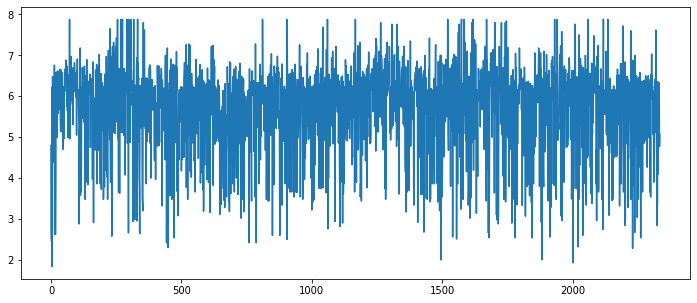

In [9]:
novel_time = range( 0, len(scores))
plt.figure( figsize=(12,5) )
sns.lineplot( x = novel_time , y = scores )
plt.show()

In [10]:
print(len(novel_time))

2335


In [11]:
#df_temperature['SMA_10'] = df_temperature.average_temperature.rolling(10, min_periods=1).mean()


In [17]:
def rolling_average(scores):
    print(len(scores))
    all_averages = []
    window_size = math.ceil( 0.10 * len(scores) )
    start_index = 0
    end_index = window_size
    
    #print( f'{start_index}:{end_index}' )    
    subset = scores[start_index:end_index]
    avg = sum(subset)/len(subset)
    all_averages.append(avg)
    #print(len(subset))
    
    while end_index < len(scores):
        
        start_index += 1
        end_index = (start_index + window_size)
        if end_index > len(scores):
            end_index = len(scores)
            
        #print( f'{start_index}:{end_index}' )
            
        subset = scores[start_index:end_index]
        
        #print(len(subset))
        avg = sum(subset)/len(subset)
        all_averages.append(avg)
    return all_averages
        
      
ra = rolling_average(scores)
print(len(ra))


2335
2102


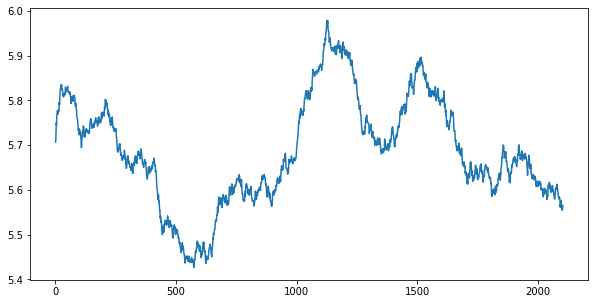

In [13]:
scores_plot = ra
novel_time = range( 1, len(scores_plot)+1)
plt.figure( figsize=(10,5) )
ax = sns.lineplot( x = novel_time , y = scores_plot )
#ax.set_xticks(novel_time)
plt.show()

In [14]:

x = ceil(len(ra)/100)
ra_dec = decimate(ra,x)
#print(ra_dec)
new_list = []

for i in range(0,len(ra)+2):
    if i % x == 0:
        new_list.append(ra[i])
new_list.append(ra[-1])
        
print(len(new_list))


97


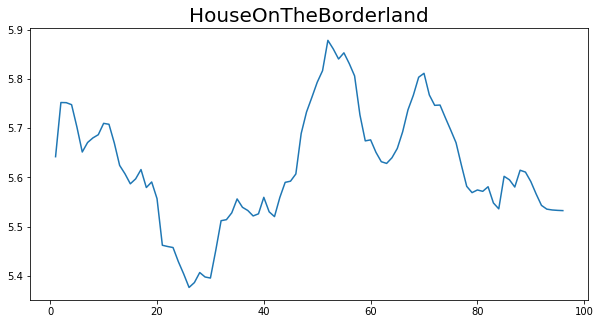

In [15]:
scores_plot = ra_dec
novel_time = range( 1, len(scores_plot)+1)
plt.figure( figsize=(10,5) )
ax = sns.lineplot( x = novel_time , y = scores_plot )
title = re.sub( r'[.]txt$' , '' , file )
ax.set_title( title  , size = 20)
#ax.set_xticks(novel_time)
img_filename = re.sub( r'txt$' , 'png' , file )
plt.savefig(img_filename)

## Sliding Window of 10,000 words


The indicated uniform length segments (gap between samples) taken from the text form the sample with fixed window size set at N(w) = 10,000 words. 

The segment length is N(s) = (N – (N(w) + 1))/n 

* N is the length of the book in words 
* n the number of points in the time series 



In [124]:
sentences = get_sentences(full_text)
word_list = word_tokenize(full_text)
nr_words = len(word_list)
print(nr_words)
num_points = 100

min_size = 1000

step = ( nr_words -min_size )/(num_points-1)
print(step*num_points)

61381
60990.90909090909


116


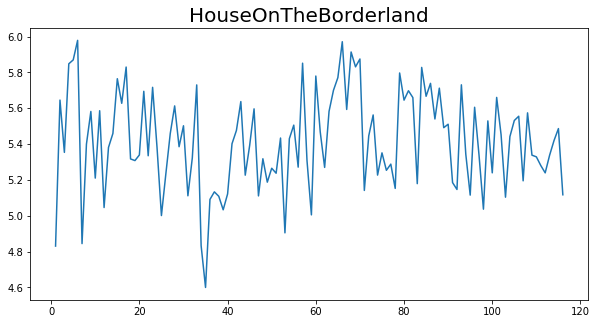

In [126]:
# make text segments
segments = []

window_size = 0 

for s in sentences:
        
    words = word_tokenize(s)
    window_size += len(words)
    segment += s + ' '
    if window_size > step:
        segments.append(segment)
        segment = ''
        window_size = 0 

if window_size > 0:
    segments.append(segment)
    

print(len(segments))



99


In [127]:
all_scores = []

for s in segments:
    words = word_tokenize(s)
    h = pyhmeter.HMeter( words , wordscores , deltah = 1.0 )
    if h.happiness_score() is not None:
        all_scores.append( h.happiness_score() )
            
print(len(all_scores))

99


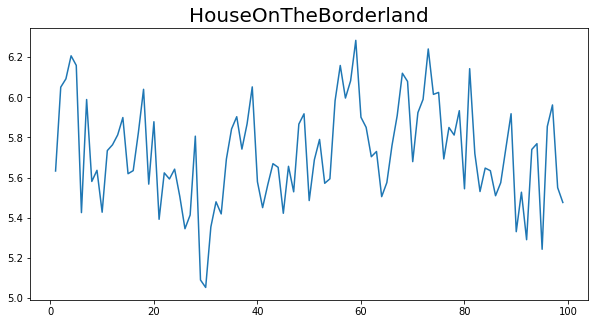

In [128]:
scores_plot = all_scores
novel_time = range( 1, len(scores_plot)+1)
plt.figure( figsize=(10,5) )
ax = sns.lineplot( x = novel_time , y = scores_plot )
title = re.sub( r'[.]txt$' , '' , file )
ax.set_title( title  , size = 20)
#ax.set_xticks(novel_time)
img_filename = re.sub( r'txt$' , 'png' , file )
plt.savefig(img_filename)